# Decission Tree



In [1]:
# Core
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)




In [2]:
# Carga de particiones
train_under = pd.read_csv("../data/bogie_train_under_1a5.csv")
valid       = pd.read_csv("../data/bogie_valid.csv")
test        = pd.read_csv("../data/bogie_test.csv")

## Definir X e y

In [3]:
# Columnas a excluir de las features
cols_to_exclude = [
    "timestamp",
    "train_id",
    "bogie_id",
    "target_fault",
    "alarm_level",
    "fault_type",
]

# Lista de columnas de entrada
all_cols = train_under.columns.tolist()
feature_cols = [c for c in all_cols if c not in cols_to_exclude]

print("Nº de features:", len(feature_cols))

# Construir X e y para cada conjunto
X_train = train_under[feature_cols].copy()
y_train = train_under["target_fault"].copy()

X_valid = valid[feature_cols].copy()
y_valid = valid["target_fault"].copy()


Nº de features: 28


Se usan solo sensores y contexto, dejando fuera ID, tiempo y variables que actúan como objetivos derivados.

In [5]:
dt = DecisionTreeClassifier(
    max_depth=5,          # profundidad moderada
    min_samples_leaf=50,  # mínimo de muestras por hoja
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [6]:
y_valid_proba = dt.predict_proba(X_valid)[:, 1]
y_valid_pred  = dt.predict(X_valid)

cm = confusion_matrix(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("Matriz de confusión (valid):\n", cm)
print("\nROC-AUC (valid):", roc)
print("PR-AUC  (valid):", pr_auc)
print("\nInforme clasificación (valid):")
print(classification_report(y_valid, y_valid_pred, digits=3))


Matriz de confusión (valid):
 [[ 8792 20135]
 [  137   309]]

ROC-AUC (valid): 0.4956885827181179
PR-AUC  (valid): 0.014851026699774391

Informe clasificación (valid):
              precision    recall  f1-score   support

         0.0      0.985     0.304     0.464     28927
         1.0      0.015     0.693     0.030       446

    accuracy                          0.310     29373
   macro avg      0.500     0.498     0.247     29373
weighted avg      0.970     0.310     0.458     29373



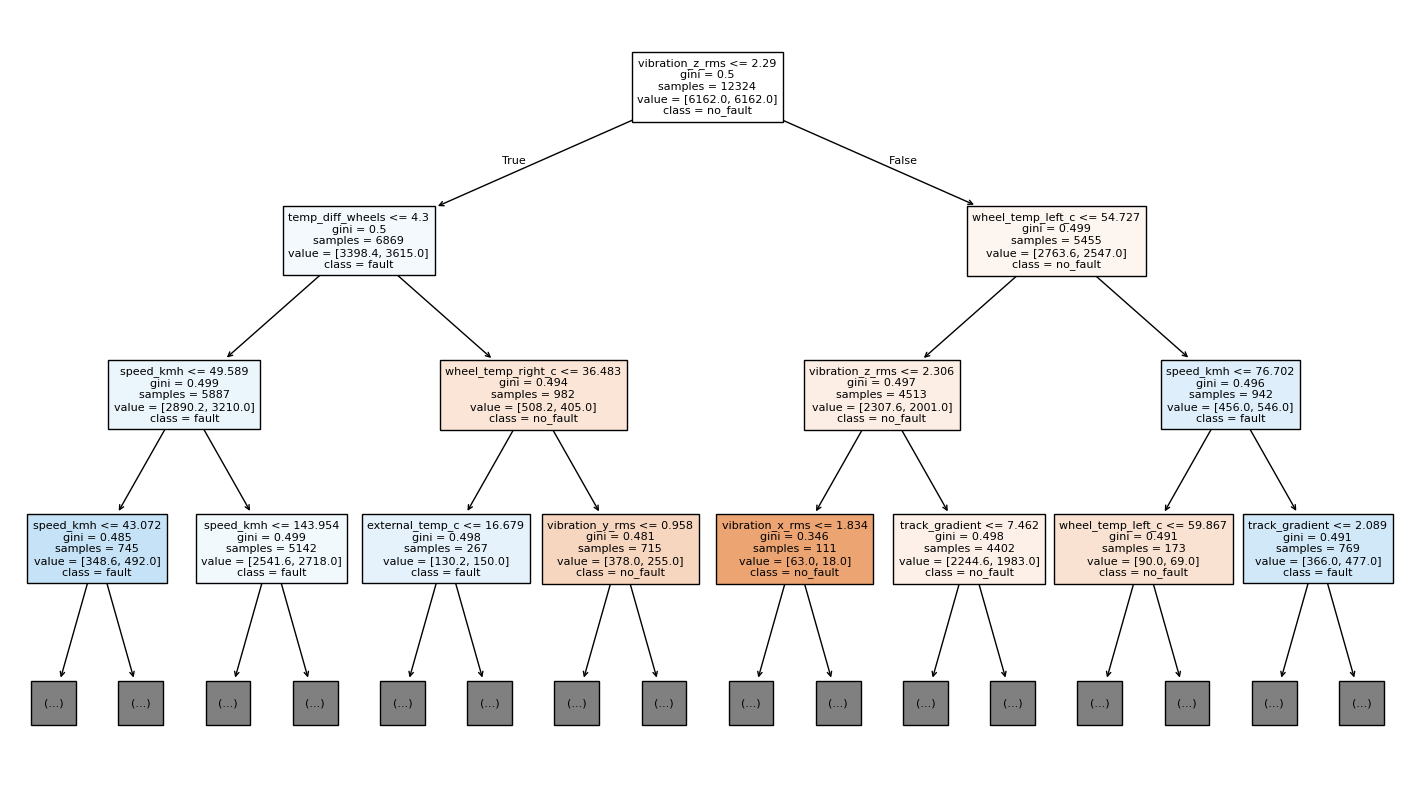

In [7]:
plt.figure(figsize=(18,10))
plot_tree(
    dt,
    feature_names=feature_cols,
    class_names=["no_fault", "fault"],
    filled=True,
    max_depth=3,   # solo las primeras capas para que se lea
    fontsize=8
)
plt.show()


### Evaluación del modelo Árbol de Decisión

- El árbol de decisión, entrenado sobre el conjunto `train_under` con una profundidad moderada y pesos de clase balanceados, muestra en validación un comportamiento similar al de la regresión logística: detecta una parte importante de los fallos, pero a costa de un número muy elevado de falsos positivos.

- En la matriz de confusión se observan 8.792 verdaderos negativos y 20.135 falsos positivos, frente a 309 verdaderos positivos y 137 falsos negativos. Esto se traduce en una precisión muy baja para la clase de fallo (≈ 1,5 %) y un recall relativamente alto (≈ 69 %).

- Las métricas agregadas (ROC-AUC ≈ 0,50 y PR-AUC ≈ 0,015) indican que, a pesar de las muchas alarmas generadas, el modelo apenas separa los casos con fallo de los casos sin fallo mejor que un clasificador aleatorio. El gran volumen de falsas alarmas haría que este sistema no fuera práctico para un entorno de mantenimiento real.

- Por tanto, este árbol de decisión se descarta como modelo final. Se utilizará únicamente como referencia dentro del conjunto de modelos probados, y será necesario explorar modelos más potentes y/o un enriquecimiento adicional de las variables para conseguir un rendimiento aceptable en la detección de fallos.
